In [69]:
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn. metrics import r2_score
import pandas as pd

In [2]:
df = pdr.get_data_tiingo('AAPL', api_key='9376141f8679e37d9bb8aedddc1c1ca4ddfbd6e8')

In [3]:
df.to_csv("AAPL.csv")

In [4]:
df = pd.read_csv("AAPL.csv")

In [5]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-04-27 00:00:00+00:00,97.82,98.71,95.68,96.000,114602142,22.741853,22.948766,22.244331,22.318727,458408568,0.0,1.0
1,AAPL,2016-04-28 00:00:00+00:00,94.83,97.88,94.25,97.610,82242690,22.046717,22.755802,21.911875,22.693030,328970760,0.0,1.0
2,AAPL,2016-04-29 00:00:00+00:00,93.74,94.72,92.51,93.990,68531478,21.793307,22.021144,21.507348,21.851428,274125912,0.0,1.0
3,AAPL,2016-05-02 00:00:00+00:00,93.64,94.08,92.40,93.965,48160104,21.770058,21.872352,21.481774,21.845616,192640416,0.0,1.0
4,AAPL,2016-05-03 00:00:00+00:00,95.18,95.74,93.68,94.200,56831277,22.128088,22.258280,21.779357,21.900251,227325108,0.0,1.0


In [6]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2021-04-19 00:00:00+00:00,134.84,135.47,133.3400,133.51,94264215,134.84,135.47,133.3400,133.51,94264215,0.0,1.0
1253,AAPL,2021-04-20 00:00:00+00:00,133.11,135.53,131.8100,135.02,94812349,133.11,135.53,131.8100,135.02,94812349,0.0,1.0
1254,AAPL,2021-04-21 00:00:00+00:00,133.50,133.75,131.3001,132.36,68847136,133.50,133.75,131.3001,132.36,68847136,0.0,1.0
1255,AAPL,2021-04-22 00:00:00+00:00,131.94,134.15,131.4100,133.04,84566456,131.94,134.15,131.4100,133.04,84566456,0.0,1.0
1256,AAPL,2021-04-23 00:00:00+00:00,134.32,135.12,132.1600,132.16,78756779,134.32,135.12,132.1600,132.16,78756779,0.0,1.0


In [7]:
df1 = df.reset_index()['close']

In [8]:
df1.shape

(1257,)

In [9]:
df1

0        97.82
1        94.83
2        93.74
3        93.64
4        95.18
         ...  
1252    134.84
1253    133.11
1254    133.50
1255    131.94
1256    134.32
Name: close, Length: 1257, dtype: float64

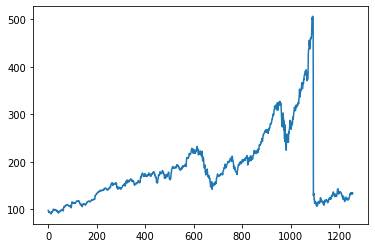

In [10]:
plt.plot(df1)

In [11]:
# LSTM are sensetive to scale of the data so we use min max scaler

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
df1

array([[0.01799158],
       [0.01079976],
       [0.00817799],
       ...,
       [0.10381239],
       [0.10006013],
       [0.10578473]])

In [14]:
# Splitting data into train and test split
training_size = int(len(df1)*0.65)
testing_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [15]:
training_size, testing_size

(817, 440)

In [16]:
len(train_data), len(test_data)

(817, 440)

In [17]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
# Reshape into X=t, t+1, t+2, t+3 and Y=t+4
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape), print(Y_train.shape)

(716, 100)
(716,)


(None, None)

In [20]:
print(X_test.shape),print(Y_test.shape)

(339, 100)
(339,)


(None, None)

In [64]:
# Reshaping inputs to be [samples, time_step, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
Y_train = Y_train.reshape(Y_train.shape[0], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

In [22]:
# Create stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))                           #stacked LSTM model
model.add(Dense(1))                           #final optput
model.compile(loss='mean_squared_error', optimizer='adam')       #compiling

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 0s 31ms/step - loss: 1.4573e-04 - val_loss: 0.0096
Epoch 2/100
12/12 [==============================] - 0s 20ms/step - loss: 1.4402e-04 - val_loss: 0.0090
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 1.4205e-04 - val_loss: 0.0093
Epoch 4/100
12/12 [==============================] - 0s 19ms/step - loss: 1.4261e-04 - val_loss: 0.0094
Epoch 5/100
12/12 [==============================] - 0s 19ms/step - loss: 1.4352e-04 - val_loss: 0.0096
Epoch 6/100
12/12 [==============================] - 0s 19ms/step - loss: 1.3940e-04 - val_loss: 0.0087
Epoch 7/100
12/12 [==============================] - 0s 19ms/step - loss: 1.4446e-04 - val_loss: 0.0085
Epoch 8/100
12/12 [==============================] - 0s 18ms/step - loss: 1.4003e-04 - val_loss: 0.0083
Epoch 9/100
12/12 [==============================] - 0s 19ms/step - loss: 1.5388e-04 - val_loss: 0.0081
Epoch 10/100
12/12 [==============================] - 0s 18ms/st

In [41]:
# Lets do the prediction and check performance matrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [42]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [71]:
# Accuracy score of the train model
train_predict = model.predict(X_train)
training_data_accuracy = r2_score(train_predict, Y_train)
print(training_data_accuracy)

0.9866726910319864


In [72]:
# Accuracy score of the test model
test_predict = model.predict(X_test)
testing_data_accuracy = r2_score(test_predict, Y_test)
print(testing_data_accuracy)

0.9374734194748512


In [43]:
# Calculate RMSE performance matrics
import math
math.sqrt(mean_squared_error(Y_train, train_predict))

168.79935687732677

In [44]:
# Test data RMSE
math.sqrt(mean_squared_error(Y_test, test_predict))

244.82046302786912

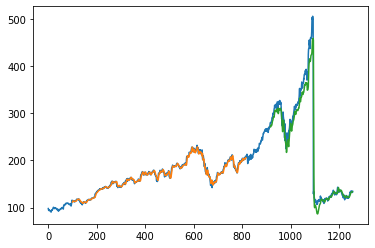

In [45]:
# Shifting train predict for plotting
look_back = 100
Train_Predict_Plot = np.empty_like(df1)
Train_Predict_Plot[:,:] = np.nan
Train_Predict_Plot[look_back: len(train_predict)+look_back, :] = train_predict

# Shifting train predict for plotting
look_back = 100
Test_Predict_Plot = np.empty_like(df1)
Test_Predict_Plot[:,:] = np.nan
Test_Predict_Plot[len(train_predict)+(look_back*2)+1 : len(df1)-1, : ] = test_predict

# Plot baselines and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(Train_Predict_Plot)
plt.plot(Test_Predict_Plot)
plt.show()

In [46]:
len(test_data)

440

In [48]:
# Predicting price for next 30 days
X_input = test_data[340:].reshape(1,-1)
X_input.shape

(1, 100)

In [49]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [50]:
temp_input

[0.06905592303066743,
 0.07788334335538183,
 0.07874924834636199,
 0.07841250751653633,
 0.07675285628382439,
 0.08036079374624172,
 0.08187612748045697,
 0.07562236921226695,
 0.0791340950090198,
 0.07713770294648226,
 0.07562236921226695,
 0.0902946482260974,
 0.0901262778111846,
 0.09226698737221883,
 0.08734816596512324,
 0.0911365003006614,
 0.09991581479254358,
 0.09770294648226097,
 0.10013229104028859,
 0.11148526758869509,
 0.10710763680096214,
 0.1043415514131088,
 0.10186410102224891,
 0.09397474443776305,
 0.0978232110643415,
 0.08721587492483462,
 0.09760673481659649,
 0.10032471437161755,
 0.09294046903187009,
 0.09250751653638006,
 0.09753457606734811,
 0.09277209861695729,
 0.08851473241130486,
 0.09017438364401681,
 0.10027660853878534,
 0.11191822008418523,
 0.11720986169573056,
 0.12647023451593503,
 0.1270475045099218,
 0.12440168370414911,
 0.11244738424533973,
 0.10010823812387254,
 0.10535177390258565,
 0.10739627179795552,
 0.10487071557426336,
 0.11316897173782

In [51]:
# Demonstrate prediction of next 30 days
lst_output = []
n_step = 100
i = 0
while (i<30):
  if (len(temp_input) > 100):
    #print temp_input
    X_input = np.array(temp_input[1:])
    print("{} day input {}".format(i, X_input))
    X_input = X_input.reshape(1,-1)
    X_input = X_input.reshape((1,n_step,1))
    #print X_input
    yhat = model.predict(X_input, verbose=0)
    print("{} day input {}".format(i, yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    #print temp_input
    lst_output.extend(yhat.tolist())
    i = i+1
  else:
    X_input = X_input.reshape((1,n_step,1))
    yhat = model.predict(X_input, verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i = i+1
  
print(lst_output)

[0.10251891]
101
1 day input [0.07788334 0.07874925 0.07841251 0.07675286 0.08036079 0.08187613
 0.07562237 0.0791341  0.0771377  0.07562237 0.09029465 0.09012628
 0.09226699 0.08734817 0.0911365  0.09991581 0.09770295 0.10013229
 0.11148527 0.10710764 0.10434155 0.1018641  0.09397474 0.09782321
 0.08721587 0.09760673 0.10032471 0.09294047 0.09250752 0.09753458
 0.0927721  0.08851473 0.09017438 0.10027661 0.11191822 0.11720986
 0.12647023 0.1270475  0.12440168 0.11244738 0.10010824 0.10535177
 0.10739627 0.10487072 0.11316897 0.11165364 0.11201443 0.10984967
 0.10835839 0.10773301 0.10831028 0.10306675 0.09741431 0.09469633
 0.09508118 0.0857727  0.08543596 0.08420926 0.07372219 0.07437162
 0.09007817 0.08365604 0.07629585 0.07165364 0.07475646 0.06258569
 0.07395069 0.07129284 0.07605532 0.0738184  0.08093806 0.08473842
 0.08279014 0.07261575 0.0713169  0.07949489 0.07745039 0.07155743
 0.07276007 0.07425135 0.07468431 0.07110042 0.07651233 0.07855683
 0.08553217 0.08627781 0.09034275

In [ ]:
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [52]:
day_new = np.arange(1,101)
day_predict = np.arange(101,131)

In [53]:
len(df1)

1257

In [54]:
df3 = df1.tolist()
df3.extend(lst_output)

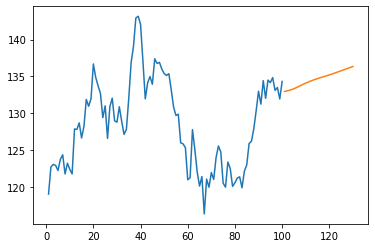

In [56]:
# To see the predicted output
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_predict,scaler.inverse_transform(lst_output))

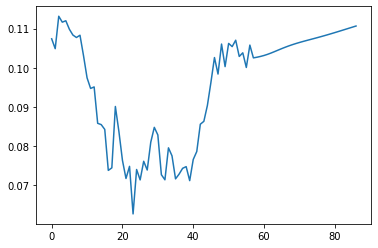

In [59]:
# To see complete output
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])